# Britter-McQuaid

The Britter-McQuaid model is based on the *Workbook on the Dispersion of Dense Gases*, by R.E. Ritter and J. McQuaid, and is a series of correlations relating maximum centerline concentrations to downwind distances that are based upon actual releases.

Currently the model ony reports the centerline concentration and does not attempt to estimate dispersion in the crosswind or vertical directions, nor does it account for plume-rise.

Starting with a scenario for a release as a given

In [1]:
using Plots
using Interpolations
using GasDispersion

In [2]:
scenario = Scenario(
    1.0,   # mass emission rate, kg/s
    10.0,  # release duration, s
    0.25,  # jet diameter, m
    15.67, # jet velocity, m/s
    1.3,   # jet density, kg/m^3
    101325,# release_pressure, Pa
    250,   # release temperature, K
    1.0,   # release height, m
    1.5,   # windspeed, m/s
    1.225, # ambient density, kg/m^3
    101325,# ambient pressure, Pa
    298.15,# ambient temperature, K
    "E",   # pasquill stability class
)

Release scenario:
    mass_emission_rate: 1.0 kg/s 
    release_duration: 10.0 s 
    jet_diameter: 0.25 m 
    jet_velocity: 15.67 m/s 
    jet_density: 1.3 kg/m^3 
    release_pressure: 101325 Pa 
    release_temperature: 250 K 
    release_height: 1.0 m 
    windspeed: 1.5 m/s 
    ambient_density: 1.225 kg/m^3 
    ambient_pressure: 101325 Pa 
    ambient_temperature: 298.15 K 
    pasquill_gifford: E  
    

## Britter-McQuaid Continuous Release

The Britter-McQuaid model is divided into continuous releases, plumes, and instantaneous releases, puffs. The plume model assumes the dense gas is being released continuously with a constant release rate $Q$.

In this example the release is more dense than ambient and it is also cooler.

In [3]:
Q = scenario.mass_emission_rate
h = scenario.release_height
ρⱼ = scenario.jet_density
Tᵣ = scenario.release_temperature

u = scenario.windspeed
ρₐ = scenario.ambient_density
Tₐ = scenario.ambient_temperature

298.15

The Britter-McQuaid model uses the windspeed at a standard height of 10m. In the scenario given the windspeed is at the release height, which is only 1m. 

We can use a power-law distribution estimate the windspeed, *u*, at any height *h*, if we have a known windspeed $u_0$ at a known height $h_0$ using the relationship

$$ {u \over u_0} = \left( h \over h_0 \right)^p $$

Where the parameters *p* are tabulated by stability class, for class E $p=0.203$

In [4]:
u₁₀ = u*(10/h)^0.203

2.3938187208550987

The model requires a few more parameters:

The reduced gravity,
$$ g_o = g { {\rho_j - \rho_a } \over \rho_a } $$

and a critical distance $D$ defined as 

$$ D = \sqrt{ V_r \over u_{10} } $$

where $Vr$ is the volumetric release rate
$$ V_r = \frac{Q}{\rho_j} $$ 

In [5]:
g = 9.80616  # gravity, m/s^2
gₒ = g * ((ρⱼ - ρₐ)/ ρₐ)

Vr = Q/ρⱼ # volumetric release rate
D = √(Vr/u₁₀)

0.5668689825891963

Britter and McQuaid suggest that a dense gas model should be used when

$$ \left( g_o V_r \over { u_{10}^3 D} \right)^{1/3} \ge 0.15 $$

In [6]:
( (gₒ * Vr) / (u₁₀^3 * D) )^(1/3) ≥ 0.15

true

The bulk of the model is a series of correlation curves relating a parameter $\alpha$ to another parameter $\beta$ for a series of concentrations, in volume fraction.
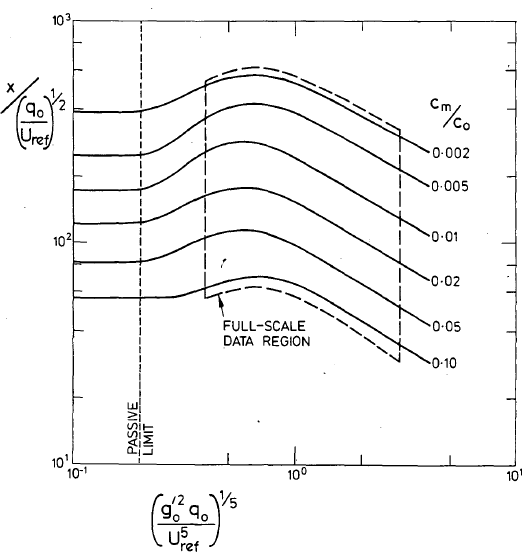

with 
$$ \alpha = 0.2 \cdot \log \left( g_o^2 V_r u_{10}^{-5} \right) $$

and 

$$ \beta = \log \left( x \over D \right) $$

Additionally, for short distances, $ x < 30D $, the following correlation should be used

$$ c = { { 306 \left( \frac{x}{D} \right)^{-2} } \over { 1 + 306 \left( \frac{x}{D} \right)^{-2} } } $$

These curves can be approximated with a series of piece-wise linear functions, which is the approach taken in *Guidelines for Chemical Process Quantitative Risk Analysis, 2nd Ed.* and the approach I am taking here. Additionally I linearly extrapolate the curves beyond the defined region.

In [7]:
Britter_McQuaid_correlations = Dict(
    0.010 => ( αs=[-1.0, -0.7, -0.29, -0.2, 1.0],
               βs=[2.25, 2.25, 2.45, 2.45, 1.83]),
    0.005 => ( αs=[-1.0, -0.67, -0.28, -0.15, 1.0],
               βs=[2.4, 2.4, 2.63, 2.63, 2.07]),
    0.020 => ( αs=[-1.0, -0.69, -0.31, -0.16, 1.0],
               βs=[2.08, 2.08, 2.25, 2.25, 1.62]),
    0.002 => ( αs=[-1.0, -0.69, -0.25, -0.13, 1.0],
               βs=[2.6, 2.6, 2.77, 2.77, 2.21]),
    0.100 => ( αs=[-1.0, -0.55, -0.14, 1.0],
               βs=[1.75, 1.75, 1.85, 1.28]),
    0.050 => ( αs=[-1.0, -0.68, -0.29, -0.18, 1.0],
               βs=[1.92, 1.92, 2.06, 2.06, 1.4]),
)

britter_interps = [ ]

concs = sort(collect(keys(Britter_McQuaid_correlations)), rev=true)

for conc in concs
    αs, βs = Britter_McQuaid_correlations[conc]
    f = LinearInterpolation(αs, βs, extrapolation_bc=Line())
    push!(britter_interps, (c=conc, it=f))
end

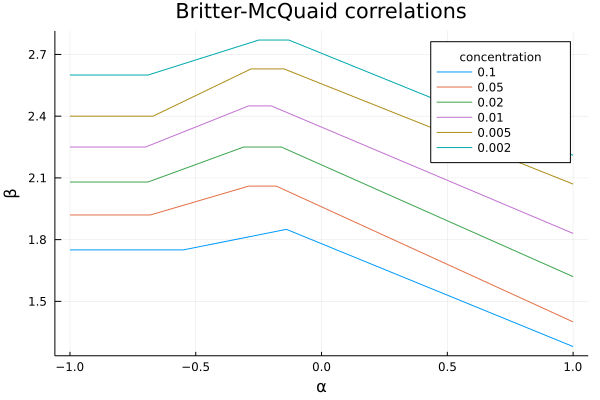

In [8]:
p1 = plot(title="Britter-McQuaid correlations",
      ylabel="β",
      xlabel="α",
      legend=:best,
      legendtitle="concentration",
      legendtitlefontsize=8)

for key in concs
    αs, βs = Britter_McQuaid_correlations[key]
    plot!(p1, αs, βs, lab=key)
end

plot(p1)

The procedure is to determine the parameter $\alpha$ for the given scenario, then for any given distance calculate $\beta$ and interpolate between the curves to find the corresponding concentration.

This can be done in julia by calculating the set of points $\left( \beta, c \right)$ for the given $\alpha$ and using `Interpolations.jl` to create an interpolation function, with the added complication that for short distances the other short distance correlation should be used instead.

In [9]:
α = 0.2*log10( gₒ^2 * Vr * u₁₀^-5 )

# calculates the points for the linear interpolation
concs = [ elem.c for elem in britter_interps ]
βs = [ elem.it(α) for elem in britter_interps ]

# linear interpolation between the short distance correlation
# and the main correlation
βs = [ log10(30); βs]
concs = [ 306*30^-2 / (1+ 306*30^-2); concs ]

# linear interpolation, extrapolates past the end with a straight line
interp = LinearInterpolation(βs, concs, extrapolation_bc=Line())

function plume_model(x)
    x′ = x/D
    if x′ < 30
        # use short distance correlation
        return x′ > 0 ? 306*x′^-2 / (1+ 306*x′^-2) : 1.0
    else
        # use linear interpolation of curve
        β = log10(x′)      
        return interp(β)
    end
end

plume_model (generic function with 1 method)

The Britter-McQuaid model assumes an isothermal case and the following correction is suggested for non-isothermal cases

$$ c^\prime = { c \over { c + (1-c) \frac{T_a}{T_r} } }$$

Where $c^\prime$ is the concentration from the correlations and $c$ the actual concentration.

re-arranging and taking $T^\prime = \frac{T_a}{T_r} $

$$ c = { { c^\prime T^\prime } \over { 1 - c^\prime + c^\prime T^\prime }}$$

The concentrations in the correlation are in terms of volume fraction, to convert to mass per volume, simply multiply by the density.

$$ c = { { \rho_j c^\prime T^\prime } \over { 1 - c^\prime + c^\prime T^\prime }} $$

In [10]:
T′ = Tₐ/Tᵣ

function c(x)
    c′ = plume_model(x)
    c = ( ρⱼ*c′*T′) / (1 - c′ + c′*T′)
    return c
end

c (generic function with 1 method)

This final form is exactly what the `GasDispersion.jl` model does.

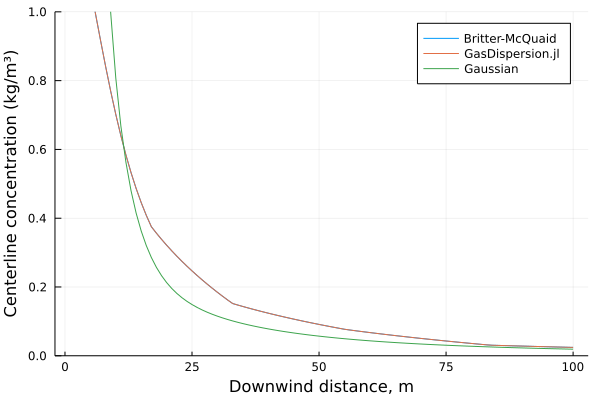

In [11]:
xs = range(1,100,length=100)

britter_mcquaid = plume(scenario, model="britter-mcquaid")
gaussian = plume(scenario, model="gaussian")

plot(xs, x->c(x), lab="Britter-McQuaid", xlabel="Downwind distance, m", ylabel="Centerline concentration (kg/m³)")
plot!(xs, x->britter_mcquaid(x, 0, 0), lab="GasDispersion.jl", ylim=(0,1))
plot!(xs, x->gaussian(x, 0, h), lab="Gaussian", ylim=(0,1))